In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # Visualization
from sklearn.preprocessing import MinMaxScaler
import torch # Library for implementing Deep Neural Network
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import random
from copy import deepcopy as dc
# import ray
# from ray import tune
# from ray.tune.schedulers import ASHAScheduler

random.seed(42)

# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

In [17]:
# Loading the Apple.Inc Stock Data
import yfinance as yf
from datetime import date, timedelta, datetime

end_date = date.today().strftime("%Y-%m-%d") #end date for our data retrieval will be current date
start_date = '1990-01-01' # Beginning date for our historical data retrieval

df = yf.download('AAPL', start=start_date, end=end_date)# Function used to fetch the data

data = df[["Close"]]
data



[*********************100%%**********************]  1 of 1 completed


,Close
Date,
1990-01-02,0.332589
1990-01-03,0.334821
1990-01-04,0.335938
1990-01-05,0.337054
1990-01-08,0.339286
...,...
2024-07-26,217.960007
2024-07-29,218.240005
2024-07-30,218.800003


In [18]:
def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 50
shifted_df = prepare_dataframe_for_lstm(data, lookback)

shifted_df["MA50"] = shifted_df.iloc[:, 1:].mean(axis=1)
shifted_df["MA20"] = shifted_df.iloc[:, 1:21].mean(axis=1)

shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7),Close(t-8),Close(t-9),...,Close(t-43),Close(t-44),Close(t-45),Close(t-46),Close(t-47),Close(t-48),Close(t-49),Close(t-50),MA50,MA20
Date,,,,,,,,,,,,,,,,,,,,,
1990-03-14,0.330357,0.329241,0.327009,0.329241,0.328125,0.315848,0.314732,0.308036,0.301339,0.305804,...,0.308036,0.321429,0.335938,0.339286,0.337054,0.335938,0.334821,0.332589,0.309509,0.309040
1990-03-15,0.328125,0.330357,0.329241,0.327009,0.329241,0.328125,0.315848,0.314732,0.308036,0.301339,...,0.308036,0.308036,0.321429,0.335938,0.339286,0.337054,0.335938,0.334821,0.309464,0.310156
1990-03-16,0.359375,0.328125,0.330357,0.329241,0.327009,0.329241,0.328125,0.315848,0.314732,0.308036,...,0.305804,0.308036,0.308036,0.321429,0.335938,0.339286,0.337054,0.335938,0.309330,0.311272
1990-03-19,0.378348,0.359375,0.328125,0.330357,0.329241,0.327009,0.329241,0.328125,0.315848,0.314732,...,0.311384,0.305804,0.308036,0.308036,0.321429,0.335938,0.339286,0.337054,0.309799,0.313951
1990-03-20,0.369420,0.378348,0.359375,0.328125,0.330357,0.329241,0.327009,0.329241,0.328125,0.315848,...,0.296875,0.311384,0.305804,0.308036,0.308036,0.321429,0.335938,0.339286,0.310625,0.317801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-26,217.960007,217.490005,218.539993,225.009995,223.960007,224.309998,224.179993,228.880005,234.820007,234.399994,...,186.880005,190.899994,192.350006,191.039993,189.869995,189.839996,189.720001,187.429993,209.098399,224.440500
2024-07-29,218.240005,217.960007,217.490005,218.539993,225.009995,223.960007,224.309998,224.179993,228.880005,234.820007,...,189.979996,186.880005,190.899994,192.350006,191.039993,189.869995,189.839996,189.720001,209.709000,224.633500
2024-07-30,218.800003,218.240005,217.960007,217.490005,218.539993,225.009995,223.960007,224.309998,224.179993,228.880005,...,189.990005,189.979996,186.880005,190.899994,192.350006,191.039993,189.869995,189.839996,210.279400,225.014500


In [19]:
shifted_df_as_numpy = shifted_df.to_numpy()

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_numpy)

shifted_df_as_np

X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

train_split = int(len(X) * 0.8)

X_train = X[:train_split]
X_test = X[train_split:]

y_train = y[:train_split]
y_test = y[train_split:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6929, 52), (1733, 52), (6929,), (1733,))

In [20]:
X_train = X_train.reshape((-1, lookback+2, 1))
X_test = X_test.reshape((-1, lookback+2, 1))
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

X_train shape: (6929, 52, 1)
X_test shape: (1733, 52, 1)


((6929, 52, 1), (1733, 52, 1), (6929, 1), (1733, 1))

In [21]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([6929, 52, 1]),
 torch.Size([1733, 52, 1]),
 torch.Size([6929, 1]),
 torch.Size([1733, 1]))

In [22]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_dataset

In [23]:
class StackedLSTM_CNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, conv_out_channels, kernel_size=3, pool_size=2, dropout=0.3):
        super(StackedLSTM_CNN, self).__init__()
        self.conv_layers = nn.ModuleList()
        self.relu_layers = nn.ModuleList()
        self.pool_layers = nn.ModuleList()
        self.lstm_layers = nn.ModuleList()
        self.dropout_layers = nn.ModuleList()

        # Ensure that the number of input channels for each convolutional layer
        # matches the number of output channels from the previous layer
        in_channels = [1] + conv_out_channels[:-1]

        for i, hidden_size in enumerate(hidden_sizes):
            # Convolutional layer
            self.conv_layers.append(nn.Conv1d(in_channels=in_channels[i], # Use the calculated in_channels
                                              out_channels=conv_out_channels[i],
                                              kernel_size=kernel_size))
            # ReLU activation layer
            self.relu_layers.append(nn.ReLU())
            # Pooling layer
            self.pool_layers.append(nn.MaxPool1d(kernel_size=pool_size))
            # LSTM layer
            self.lstm_layers.append(nn.LSTM(conv_out_channels[i], hidden_size, batch_first=True))
            # Dropout layer
            self.dropout_layers.append(nn.Dropout(dropout))

        # Final linear layer
        self.linear = nn.Linear(hidden_sizes[-1], 1)

    def forward(self, x):
        batch_size = x.size(0)
        outputs = x

        for conv, relu, pool, lstm, dropout in zip(self.conv_layers, self.relu_layers, self.pool_layers, self.lstm_layers, self.dropout_layers):
            # Apply convolutional layer
            outputs = conv(outputs.transpose(1, 2))  # Change shape for Conv1d
            # Apply ReLU activation
            outputs = relu(outputs)
            # Apply pooling layer
            outputs = pool(outputs)
            # Change shape back for LSTM
            outputs = outputs.transpose(1, 2)
            # Apply LSTM layer
            outputs, _ = lstm(outputs)  # Discard cell states for simplicity
            # Apply dropout
            outputs = dropout(outputs)

        outputs = outputs[:, -1, :]
        return self.linear(outputs)

model1 = StackedLSTM_CNN(input_size=X_train.shape[1],
                        hidden_sizes=[25, 25],
                        conv_out_channels=[25, 25])
model1.to(device)

StackedLSTM_CNN(
  (conv_layers): ModuleList(
    (0): Conv1d(1, 25, kernel_size=(3,), stride=(1,))
    (1): Conv1d(25, 25, kernel_size=(3,), stride=(1,))
  )
  (relu_layers): ModuleList(
    (0-1): 2 x ReLU()
  )
  (pool_layers): ModuleList(
    (0-1): 2 x MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm_layers): ModuleList(
    (0-1): 2 x LSTM(25, 25, batch_first=True)
  )
  (dropout_layers): ModuleList(
    (0-1): 2 x Dropout(p=0.3, inplace=False)
  )
  (linear): Linear(in_features=25, out_features=1, bias=True)
)

In [24]:
class StackedLSTM(nn.Module):
  def __init__(self, input_size, hidden_sizes, dropout=0.3):
    super(StackedLSTM, self).__init__()
    self.lstm_layers = nn.ModuleList()
    self.dropout_layers = nn.ModuleList()

    # Define LSTM layers with decreasing hidden size
    for i, hidden_size in enumerate(hidden_sizes):
      self.lstm_layers.append(nn.LSTM(input_size if i == 0 else hidden_sizes[i-1], hidden_size))
      self.dropout_layers.append(nn.Dropout(dropout))

    # Final linear layer
    self.linear = nn.Linear(hidden_sizes[-1], 1)

  def forward(self, x):
    batch_size = x.size(0)
    outputs = x.transpose(1,2)

    for lstm, dropout in zip(self.lstm_layers, self.dropout_layers):
      outputs, _ = lstm(outputs)  # Discard cell states for simplicity
      outputs = dropout(outputs)

    outputs = outputs[:, -1, :]
    return self.linear(outputs)

# Example Usage
model = StackedLSTM(X_train.shape[1], hidden_sizes=[26])
model.to(device)
model

StackedLSTM(
  (lstm_layers): ModuleList(
    (0): LSTM(52, 26)
  )
  (dropout_layers): ModuleList(
    (0): Dropout(p=0.3, inplace=False)
  )
  (linear): Linear(in_features=26, out_features=1, bias=True)
)

In [25]:
import math

num_epochs = 50

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

max_lr = 1e-4
min_lr = max_lr * 0.1
warmup_steps = 200
max_steps = 500

def get_lr(it):
    # 1) linear warmup for warmup_iters steps
    if it < warmup_steps:
        return max_lr * (it+1) / warmup_steps
    # 2) if it > lr_decay_iters, return min learning rate
    if it > max_steps:
        return min_lr
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - warmup_steps) / (max_steps - warmup_steps)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff starts at 1 and goes to 0
    return min_lr + coeff * (max_lr - min_lr)

loss_function = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr)

torch.set_float32_matmul_precision('high')

In [26]:
def train_one_epoch(model):
    # model = torch.compile(model)
    model.train(True)
    print(f'Epoch: {epoch + 1}')

    running_loss = 0.0  # Initialize running_loss

    train_loader_tmp = dc(train_loader)

    for batch_index, batch in enumerate(train_loader_tmp):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        # Normalize input data if not already done
        x_batch = (x_batch - x_batch.mean(dim=0)) / x_batch.std(dim=0)

        # Forward pass through the model
        optimizer.zero_grad()

        with torch.autocast(device_type=device, dtype=torch.bfloat16):
          output = model(x_batch)

          # Clamp outputs to avoid extreme values
          output = torch.clamp(output, min=-1e9, max=1e9)

          # Calculate loss
          loss = loss_function(output, y_batch[:, 0])

        if torch.isnan(loss):
            print("NaN loss detected")
            continue

        running_loss += loss.item()

        # Backward pass and optimization
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Learning rate scheduling
        for param_group in optimizer.param_groups:
            param_group['lr'] = get_lr(epoch * len(train_loader) + batch_index)

        # Check for NaN in gradients
        for name, param in model.named_parameters():
            if param.grad is not None and torch.isnan(param.grad).any():
                print(f"NaN found in gradients of {name}")

        optimizer.step()

    print(f'Training Loss: {running_loss / len(train_loader)}')

def validate_one_epoch(model):
    model.eval()
    running_loss = 0.0

    test_loader_tmp = dc(test_loader)

    for batch_index, batch in enumerate(test_loader_tmp):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.inference_mode():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [27]:
print("LSTM:")
for epoch in range(num_epochs):
    train_one_epoch(model=model)
    validate_one_epoch(model=model)

print("LSTM-CNN:")
for epoch in range(5):
    train_one_epoch(model=model1)
    validate_one_epoch(model=model1)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


LSTM:
Epoch: 1


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([17, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Training Loss: 0.6955651002270835
Val Loss: 0.140
***************************************************

Epoch: 2
Training Loss: 0.1216630390265845
Val Loss: 0.286
***************************************************

Epoch: 3
Training Loss: 0.06624477756668895
Val Loss: 0.304
***************************************************

Epoch: 4
Training Loss: 0.06285516569210638
Val Loss: 0.314
***************************************************

Epoch: 5
Training Loss: 0.06122408350629191
Val Loss: 0.323
***************************************************

Epoch: 6
Training Loss: 0.05916139152124181
Val Loss: 0.330
***************************************************

Epoch: 7
Training Loss: 0.05934855353928382
Val Loss: 0.336
***************************************************

Epoch: 8
Training Loss: 0.05883200893238667
Val Loss: 0.339
***************************************************

Epoch: 9
Training Loss: 0.05866141151207658
Val Loss: 0.341
***********************************************

In [28]:
def plot(model):
  test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

  dummies = np.zeros((X_test.shape[0], lookback+3))
  dummies[:, 0] = test_predictions
  dummies = scaler.inverse_transform(dummies)

  test_predictions = dc(dummies[:, 0])
  test_predictions
  dummies = np.zeros((X_test.shape[0], lookback+3))
  dummies[:, 0] = y_test.flatten()
  dummies = scaler.inverse_transform(dummies)

  new_y_test = dc(dummies[:, 0])
  new_y_test
  plt.plot(new_y_test, label='Actual Close')
  plt.plot(test_predictions, label='Predicted Close')
  plt.xlabel('Day')
  plt.ylabel('Close')
  plt.legend()
  plt.show()

LSTM:


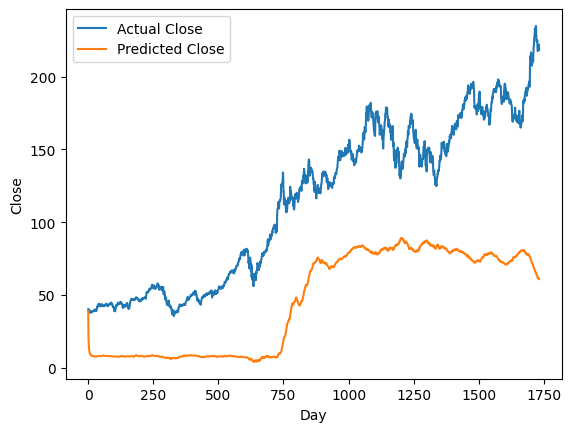

LSTM-CNN:


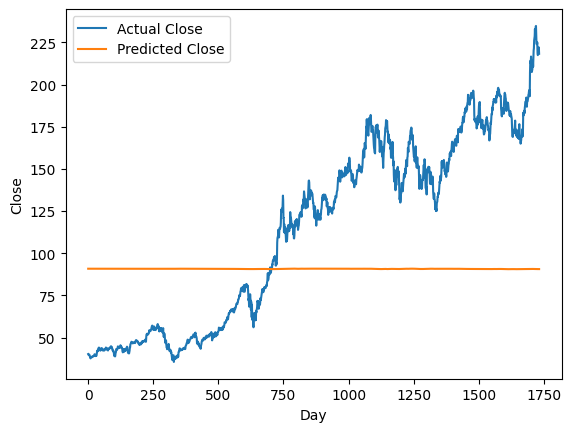

In [29]:
print("LSTM:")
plot(model)
print("LSTM-CNN:")
plot(model1)